In [11]:
# load packages
import pandas as pd
import seaborn as sns
# import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import math
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import utils.prepareDataCSV as prepare
import utils.baselineModels as baseline
import utils.train as train
import utils.plot as p

import torch
import torch.nn.functional as F
# from torch.utils import data
from torchinfo import summary
import torch.nn as nn
# import torch.optim as optim
%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [53]:
train7path = '../../data/processed/stock3/moreX_test8_part3.csv'
df = pd.read_csv(train7path)
df

,0,1,2,3,4,5,6,7,8,9,...,147,148,midprice,MPchange,y10,OI,OIR,spread,OIstd,OIRstd
0,0.1291,0.02500,0.1289,0.01500,0.1292,0.04273,0.1288,0.01000,0.1293,0.0444,...,2.0,2.0,0.12900,0.0,1,0.00000,-0.250000,0.0002,-0.024253,-0.680427
1,0.1291,0.02500,0.1289,0.01000,0.1292,0.04273,0.1288,0.00500,0.1293,0.0444,...,2.0,2.0,0.12900,0.0,1,-0.00500,-0.428571,0.0002,-1.939917,-1.126842
2,0.1291,0.02500,0.1289,0.01000,0.1292,0.04273,0.1288,0.00500,0.1293,0.0444,...,2.0,2.0,0.12900,0.0,1,0.00000,-0.428571,0.0002,-0.024253,-1.126842
3,0.1291,0.02500,0.1289,0.01500,0.1292,0.04273,0.1288,0.01000,0.1293,0.0444,...,2.0,2.0,0.12900,0.0,1,0.00500,-0.250000,0.0002,1.891410,-0.680427
4,0.1291,0.02500,0.1289,0.01500,0.1292,0.04273,0.1288,0.01000,0.1293,0.0444,...,2.0,2.0,0.12900,0.0,1,0.00000,-0.250000,0.0002,-0.024253,-0.680427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10429,0.3644,0.00200,0.3639,0.00129,0.3645,0.00200,0.3635,0.00200,0.3646,0.0020,...,2.0,2.0,0.36415,0.0,1,-0.00375,-0.215805,0.0005,-0.598952,-0.271246
10430,0.3644,0.00200,0.3639,0.00129,0.3645,0.00200,0.3635,0.00200,0.3646,0.0020,...,2.0,2.0,0.36415,0.0,1,0.00000,-0.215805,0.0005,-0.024253,-0.271246
10431,0.3644,0.00200,0.3639,0.00129,0.3645,0.00200,0.3634,0.00076,0.3646,0.0020,...,2.0,2.0,0.36415,0.0,1,0.00000,-0.215805,0.0005,-0.024253,-0.271246
10432,0.3644,0.00200,0.3639,0.00129,0.3645,0.00200,0.3634,0.00076,0.3646,0.0020,...,3.0,2.0,0.36415,0.0,1,0.00000,-0.215805,0.0005,-0.024253,-0.271246


In [19]:
train7path = '../../data/processed/stock3/moreX_train7_part3.csv'
test7path = '../../data/processed/stock3/moreX_test7_part3.csv'
test8path = '../../data/processed/stock3/moreX_test8_part3.csv'
test9path = '../../data/processed/stock3/moreX_test9_part3.csv'
dec_train, dec_val, dec_test = prepare.splitDataset(0.8,0.8,train7path,test7path,test8path,test9path)
train_loader, val_loader, test_loader = prepare.getDataLoader(dec_train,dec_val,dec_test,k=-6,num_classes=3,T=100,batch_size=64)

In [20]:
model = baseline.LstmNet(y_len=3, device=device, hidden_size=64)
model.to(device)

LstmNet(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): Tanh()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (4): Tanh()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 10), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32

In [5]:
summary(model, (64, 1, 100, 42))

Layer (type:depth-idx)                   Output Shape              Param #
LstmNet                                  --                        --
├─Sequential: 1-1                        [64, 32, 97, 21]          --
│    └─Conv2d: 2-1                       [64, 32, 100, 21]         96
│    └─LeakyReLU: 2-2                    [64, 32, 100, 21]         --
│    └─BatchNorm2d: 2-3                  [64, 32, 100, 21]         64
│    └─Conv2d: 2-4                       [64, 32, 97, 21]          4,128
│    └─LeakyReLU: 2-5                    [64, 32, 97, 21]          --
│    └─BatchNorm2d: 2-6                  [64, 32, 97, 21]          64
├─Sequential: 1-2                        [64, 32, 94, 10]          --
│    └─Conv2d: 2-7                       [64, 32, 97, 10]          2,080
│    └─Tanh: 2-8                         [64, 32, 97, 10]          --
│    └─BatchNorm2d: 2-9                  [64, 32, 97, 10]          64
│    └─Conv2d: 2-10                      [64, 32, 94, 10]          4,128
│    └

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
train_losses, val_losses = train.batch_gd(model, criterion, optimizer, train_loader, val_loader, epochs=50, device=device, savedModelName='./savedModels_rightOrder/moreX_LSTM')

  2%|▏         | 1/50 [00:06<04:59,  6.12s/it]

model saved
Epoch 1/50, Train Loss: 1.0910,           Validation Loss: 1.0800, Duration: 0:00:06.117355, Best Val Epoch: 0


  4%|▍         | 2/50 [00:11<04:41,  5.86s/it]

model saved
Epoch 2/50, Train Loss: 1.0689,           Validation Loss: 1.0774, Duration: 0:00:05.680610, Best Val Epoch: 1


  6%|▌         | 3/50 [00:17<04:36,  5.89s/it]

model saved
Epoch 3/50, Train Loss: 1.0494,           Validation Loss: 1.0765, Duration: 0:00:05.912547, Best Val Epoch: 2


  8%|▊         | 4/50 [00:23<04:33,  5.95s/it]

model saved
Epoch 4/50, Train Loss: 1.0326,           Validation Loss: 1.0759, Duration: 0:00:06.044940, Best Val Epoch: 3


 10%|█         | 5/50 [00:29<04:26,  5.92s/it]

Epoch 5/50, Train Loss: 1.0194,           Validation Loss: 1.0762, Duration: 0:00:05.858500, Best Val Epoch: 3


 12%|█▏        | 6/50 [00:35<04:18,  5.89s/it]

model saved
Epoch 6/50, Train Loss: 1.0050,           Validation Loss: 1.0751, Duration: 0:00:05.822599, Best Val Epoch: 5


 14%|█▍        | 7/50 [00:41<04:13,  5.90s/it]

Epoch 7/50, Train Loss: 0.9948,           Validation Loss: 1.0782, Duration: 0:00:05.919818, Best Val Epoch: 5


 16%|█▌        | 8/50 [00:46<04:00,  5.74s/it]

Epoch 8/50, Train Loss: 0.9872,           Validation Loss: 1.0761, Duration: 0:00:05.393815, Best Val Epoch: 5


 18%|█▊        | 9/50 [00:52<03:53,  5.68s/it]

Epoch 9/50, Train Loss: 0.9797,           Validation Loss: 1.0799, Duration: 0:00:05.562286, Best Val Epoch: 5


 20%|██        | 10/50 [00:58<03:53,  5.83s/it]

Epoch 10/50, Train Loss: 0.9738,           Validation Loss: 1.0776, Duration: 0:00:06.147613, Best Val Epoch: 5


 22%|██▏       | 11/50 [01:04<03:47,  5.82s/it]

Epoch 11/50, Train Loss: 0.9680,           Validation Loss: 1.0766, Duration: 0:00:05.809471, Best Val Epoch: 5


 22%|██▏       | 11/50 [01:04<03:49,  5.89s/it]


KeyboardInterrupt: 

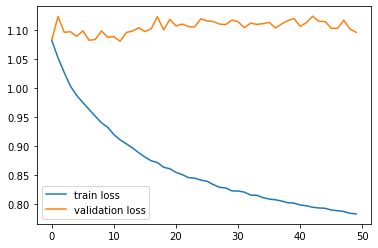

In [ ]:
p.drawLossChange(train_losses, val_losses)

In [ ]:
model = torch.load('./savedModels_rightOrder/moreX_LSTM')
all_targets, all_predictions = p.getReport(test_loader, model, device)

              precision    recall  f1-score   support

           0     0.4053    0.3327    0.3654      9153
           1     0.4157    0.4127    0.4142      9243
           2     0.4230    0.4995    0.4581      9421

    accuracy                         0.4158     27817
   macro avg     0.4146    0.4150    0.4126     27817
weighted avg     0.4147    0.4158    0.4130     27817



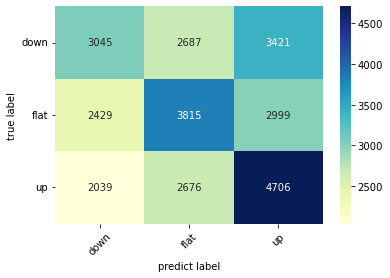

In [ ]:
p.seeConfusionMatrix(all_targets,all_predictions) 

### 查看y和2个新特征之间的相关性

In [33]:
y = np.array(df['y10'])
OIstd = np.array(df['OIstd'])
OIRstd = np.array(df['OIRstd'])

my_rho = np.corrcoef(OIstd, y)
print(my_rho)

[[1.         0.04970096]
 [0.04970096 1.        ]]


### 画箱式图

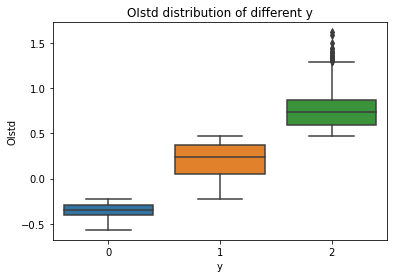

In [52]:
fig, axes = plt.subplots()
sns.boxplot( x=df["y10"], y=df["MPchange"] )
title = "OIstd distribution of different y"

props = {'title': title,
             'xlabel': 'y',
             'ylabel': 'OIstd',
             }
axes.set(**props)
plt.show()

### 画ACF

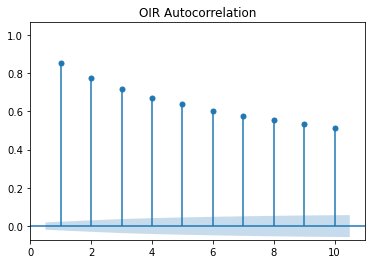

In [7]:
##ACF function for the OIR-ResampledData
from statsmodels.graphics.tsaplots import plot_acf
fig, axes = plt.subplots()

plot_acf(OIRstd, ax=axes, lags = np.arange(1,11), title = 'OIR Autocorrelation', auto_ylims=True)

plt.show()

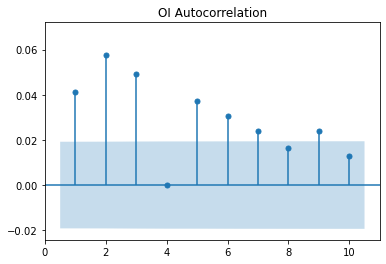

In [9]:
fig, axes = plt.subplots()
plot_acf(OIstd, ax=axes, lags = np.arange(1,11), title = 'OI Autocorrelation', auto_ylims=True)
plt.show()

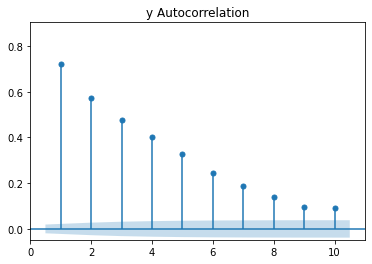

In [10]:
fig, axes = plt.subplots()
plot_acf(y, ax=axes, lags = np.arange(1,11), title = 'y Autocorrelation', auto_ylims=True)
plt.show()